In [1]:
import json

import shap
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt

2025-01-25 10:06:13.584697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Model & Dataset

In [2]:
"""
shap.datasets.imagenet50():
- Dataset was collected by searching images similar to the original ImageNet images on Google image search
- Thus, labels may not be correct
"""


# load pre-trained model and data
model = ResNet50(weights="imagenet")
X, y = shap.datasets.imagenet50()
X = X.astype(np.uint8)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

2025-01-25 10:06:14.744884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-25 10:06:14.754521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-25 10:06:14.755068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-25 10:06:14.756442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

X: (50, 224, 224, 3)
y: (50,)


In [3]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [4]:
len(class_names)

1000

In [5]:
class_names[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## PartitionShap Example

### Example1: small value of `max_eval`

In [6]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    tmp = preprocess_input(tmp)
    # output shape: (batch_size, 1000)
    return model(tmp)

In [7]:
"""
Available mask_value options in shap.maskers.Image:
- blur(kernel_xsize, kernel_xsize)
    - applies Gaussian Blur to fill the masked region
    - use neighboring pixel average value
- inpant_telea
    - applies Telea to fill the masked region
    - interpolate the masked region using neighboring pixels
- inpaint_ns
    - applies Navier-Stokes (NS) to fill the masked region
    - interpolate the masked region based-on physical simulaton
    - generally well preserves original image characteristics
"""

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

In [8]:
"""
shap.Explainer
- A wrapper class that automatically determines the appropriate explainer based on the given model & masker
- Since the masker defined above is defined on the image data (masker.image_data is True),
  shap.Explainer will use PartitionSHAP which computes Shapley Values recursively through a hierarchy of features,
  this hierarchy defines feature coalitions and results in the Owen values from game theory
- Reference
  - https://shap.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html#shap.PartitionExplainer
"""

# create an explainer with model and image masker
explainer = shap.Explainer(
    f,
    masker=masker,
    output_names=class_names
)

print(f"Explainer Class: {explainer.__class__}")

Explainer Class: <class 'shap.explainers._partition.PartitionExplainer'>


In [9]:
"""
max_evals
- Recommended number of evaluations is 300-500 to get explanations with sufficient granularity for the super pixels.

shap.Explanation.argsort.flip[:4]
- Returns k labels with the highest probability (argsort.flip => highest)
- Reference
  - https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html
"""

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:3],
    max_evals=500,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip[:5]
)

2025-01-25 10:06:19.163105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50% 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:24, 12.09s/it]   


In [10]:
# (batch_size, height, width, channel, top-k)

shap_values.values.shape

(2, 224, 224, 3, 5)

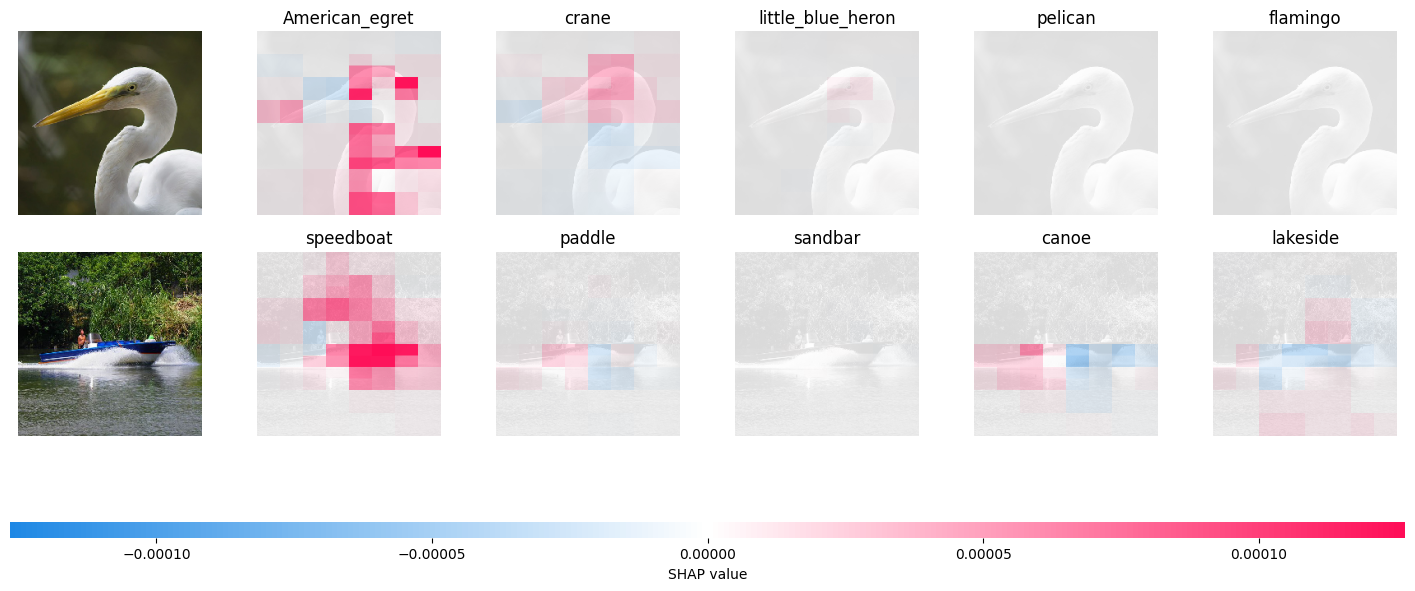

In [11]:
"""
red: pixels with high shap values (positive effect on class prediction)
blue: pixels with low shap values (negative effect on class prediction)
"""

shap.image_plot(shap_values)

### Example2: large value of `max_eval`

In [12]:
# define a masker that is used to mask out partitions of the input image.

masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

In [14]:
# create an explainer with model and image masker

explainer_blur = shap.Explainer(
    f,
    masker=masker_blur,
    output_names=class_names
)

print(f"Explainer Class: {explainer.__class__}")

Explainer Class: <class 'shap.explainers._partition.PartitionExplainer'>


In [15]:
# here we explain two images using 5000 evaluations of the underlying model to estimate the SHAP values

shap_values_fine = explainer_blur(
    X[1:3],
    max_evals=5000,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50% 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:33, 16.57s/it]   


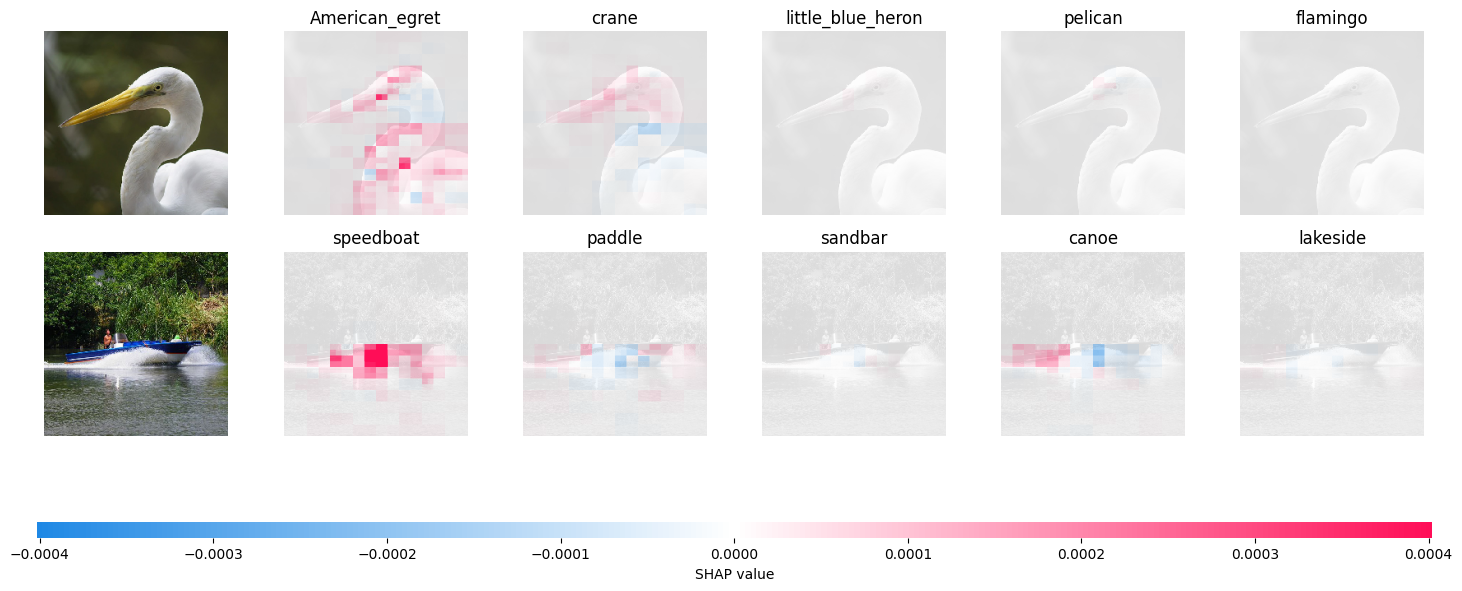

In [16]:
"""
red: pixels with high shap values (positive effect on class prediction)
blue: pixels with low shap values (negative effect on class prediction)
"""

# output with shap values
shap.image_plot(shap_values_fine)

## References
- https://shap.readthedocs.io/en/latest/image_examples.html